In [40]:
import pandas as pd
from plotly import graph_objects as go
from pathlib import Path
import os
if not Path("jw_utils").exists():
    !git clone https://github.com/JonWinkelman/jw_utils
from jw_utils import parse_fasta as pfa
from jw_utils import parse_gff as pgf
from jw_utils import dna_utils as du
from jw_utils import plotly_preferences as pprefs
import external_functions as ef
import importlib 
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import bisect
from pathlib import Path
import plotly.io as pio

### Fill out file paths

In [ ]:
comp_genome_fps = {
    '3FF69J_1_1_genome_fp' : Path("./data/3FF69J_results/3FF69J_1_1.1/3FF69J_1_1.1_1_reference.fasta"),
    '3FF69J_2_2_genome_fp' : Path("./data/3FF69J_results/3FF69J_2_2.2/3FF69J_2_2.2_1_reference.fasta")
}

ref_genome_fp        = Path('./references/GCA_000196175.1_ASM19617v1_genomic.fna')
ref_genome_gff_fp    = Path('./references/genomic.gff')

#### Make directories

In [55]:
comp_results_dirs = {}
for name in comp_genome_fps:
    comp_dir = Path(f"./results/{name.replace('_genome_fp', '')}/")
    image_dir = comp_dir  / 'images'
    image_dir.mkdir(exist_ok=True, parents=True)
    comp_results_dirs[name] = comp_dir

## Get SNPs and small indels

In [54]:
ref_genome_d = pfa.get_seq_dict(ref_genome_fp)
comp_genome_ds = {}
for name, comp_genome_fp in comp_genome_fps.items(): 
    comp_genome_ds[name] = pfa.get_seq_dict(comp_genome_fp)

In [84]:
def make_dnadiff_comp(ref_genome_fp, comp_genome, outdir):
    comp = comp_genome.absolute()
    ref = ref_genome_fp.absolute()
    working_dir = os.getcwd()
    os.chdir(outdir)
    !dnadiff $ref $comp
    !mummerplot --png  --layout --fat out.delta
    os.chdir(working_dir)


snp_df_d       = {}
snp_annot_df_d = {}
for name, comp_genome_fp in comp_genome_fps.items(): 
    outdir = comp_results_dirs[name] / f'dnadiff/{comp_genome_fp.stem}'
    outdir.mkdir(exist_ok=True, parents=True)
    make_dnadiff_comp(ref_genome_fp, comp_genome_fp, outdir)
    snps_fp = outdir / 'out.snps'
    snps_df  = ef.make_snp_df(snps_fp)
    snps_df.to_csv(outdir /  'out.snps.csv')
    snp_df_d[name] = snps_df
    annot_df = pgf.make_simple_annot_df(ref_genome_gff_fp, start_end=True, contig=True)
    snps_annot_df = ef.map_snps_to_genes(snps_df, annot_df)
    snps_annot_df.to_csv(outdir / 'out.snps_annot.csv')
    snp_annot_df_d[name]= snps_annot_df
    snp_annot_df_d[name].to_csv(comp_results_dirs[name] / f"SNPs_annots_{name.replace('genome_fp', '')}.csv" )
    snp_df_d[name].to_csv(      comp_results_dirs[name] / f"SNPs_{name.replace('genome_fp', '')}.csv"        )

ref_genome_d = pfa.get_seq_dict(ref_genome_fp)

Building alignments
1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "out.ntref" of length 3782951
# construct suffix tree for sequence of length 3782951
# (maximum reference length is 2305843009213693948)
# (maximum query length is 18446744073709551615)
# process 37829 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /Users/jonathanwinkelman/miniconda3/envs/mummer/opt/mummer-3.23/mummer out.ntref 0.69
# reading input file "/Users/jonathanwinkelman/Trestle/Mukherjee_lab/20260105_analiml_bdello_genome_comp/mummer_genome_comparison/data/3FF69J_results/3FF69J_1_1.1/3FF69J_1_1.1_1_reference.fasta" of length 3789023
# matching query-file "/Users/jonathanwinkelman/Trestle/Mukherjee_lab/20260105_analiml_bdello_genome_comp/mummer_genome_comparison/data/3FF69J_results/3FF69J_1_1.1/3FF69J_1_1.1_1_reference.fasta"
# against subject-file "out.ntref"
# COMPLETETIME /Users/jonat

| Col # | Meaning                           |
| ----- | --------------------------------- |
| 1     | `ref_pos` — position in reference |
| 2     | `ref_base`                        |
| 3     | `query_base`                      |
| 4     | `query_pos`                       |
| 5     | `ref_pos_in_aln`                  |
| 6     | `query_pos_in_aln`                |
| 7     | `ref_contig_len`                  |
| 8     | `query_contig_len`                |
| 9     | `ref_strand`                      |
| 10    | `query_strand`                    |
| 11    | `ref_contig`                      |
| 12    | `query_contig`                    |  

. in ref_base → insertion in query  
. in query_base → deletion in query  
query_strand = -1 → alignment is reversed (inversion or opposite orientation)  
Multiple rows with same ref_pos → multi-base indels (expected)  


### Get large deletions, insertions and flips

In [82]:
def nucmer_analysis(comp_genome, ref_genome_fp, out_dir): 
    comp_genome = Path(comp_genome)
    ref_genome_fp = Path(ref_genome_fp)
    #nucmer_outdir = Path(f'./results/nucmer/{comp_genome.stem}')
    wd = os.getcwd()
    ref = ref_genome_fp.absolute()
    comp = comp_genome.absolute()
    os.chdir(nucmer_outdir)
    !nucmer $ref $comp
    os.chdir(wd)
    delta_fp           = nucmer_outdir / 'out.delta'
    show_coords_out_fp = delta_fp.with_suffix('.show_coords')
    !show-coords $delta_fp > $show_coords_out_fp
    return ef.parse_show_coords(show_coords_out_fp)


show_coords_df_d = {}
for name, comp_genome_fp in comp_genome_fps.items(): 
    nucmer_outdir = comp_results_dirs[name] / f"nucmer/{name.replace('_genome_fp', '')}"
    nucmer_outdir.mkdir(exist_ok=True, parents=True)
    show_coords_df_d[name] = nucmer_analysis(comp_genome_fp, ref_genome_fp, nucmer_outdir)
    show_coords_df_d[name].to_csv(comp_results_dirs[name] / f"{name.replace('_genome_fp', '')}_show_coords.csv")    
    

1: PREPARING DATA
2,3: RUNNING mummer AND CREATING CLUSTERS
# reading input file "out.ntref" of length 3782951
# construct suffix tree for sequence of length 3782951
# (maximum reference length is 2305843009213693948)
# (maximum query length is 18446744073709551615)
# process 37829 characters per dot
#....................................................................................................
# CONSTRUCTIONTIME /Users/jonathanwinkelman/miniconda3/envs/mummer/opt/mummer-3.23/mummer out.ntref 0.70
# reading input file "/Users/jonathanwinkelman/Trestle/Mukherjee_lab/20260105_analiml_bdello_genome_comp/mummer_genome_comparison/data/3FF69J_results/3FF69J_1_1.1/3FF69J_1_1.1_1_reference.fasta" of length 3789023
# matching query-file "/Users/jonathanwinkelman/Trestle/Mukherjee_lab/20260105_analiml_bdello_genome_comp/mummer_genome_comparison/data/3FF69J_results/3FF69J_1_1.1/3FF69J_1_1.1_1_reference.fasta"
# against subject-file "out.ntref"
# COMPLETETIME /Users/jonathanwinkelman/minicon

In [80]:
def get_inserted_seqs(comp_genome_fp, ref_genome_fp, show_coords_df, ):
    """"""
    comp_genome_d      = pfa.get_seq_dict(comp_genome_fp)
    
    # get length of reference genome
    ref_genome_d  = pfa.get_seq_dict(ref_genome_fp)
    total_ref_len = 0
    for refname, seq in ref_genome_d.items(): 
        total_ref_len = total_ref_len + len(seq) 
    inserted_seqs ={contig:{} for contig in comp_genome_d}
    col_d = {
        'contig_names'    :[],
        'start_position'  :[],
        'end_position'    :[],
        'insertion_seq'   :[],
        'insertion_length':[]
    }

    for contig_name, seq in comp_genome_d.items(): 
        t_df = show_coords_df[show_coords_df['Tag2'] == contig_name]
        gaps = ef.unaligned_segments(t_df['S2'], t_df['E2'], ref_len=len(seq))
        for gap in gaps:
            s,e = gap
            length = abs(e-s)
            if length > 1:
                col_d['contig_names'].append(contig_name)
                col_d['start_position'].append(s)
                col_d['end_position'].append(e)
                col_d['insertion_seq'].append(comp_genome_d[contig_name][s:e])
                col_d['insertion_length'].append(length)
    insert_df = pd.DataFrame(col_d) 
    return insert_df


inserted_seqs_dfs = {}
for name, comp_genome_fp in comp_genome_fps.items(): 
    inserted_seqs_dfs[name] = get_inserted_seqs(comp_genome_fp, ref_genome_fp, show_coords_df_d[name])
    inserted_seqs_dfs[name].to_csv(comp_results_dirs[name] / f'{name}_inserted_sequences.csv')

In [81]:

def make_global_alignment_map(df, ref_genome_d, height=1, fig_width=800, title=''):
    """"""
    ## make reference trace
    fig=make_subplots(rows=2, cols=1, shared_xaxes=True)
    if len(ref_genome_d) > 1:
        raise Exception(f"This is currently set up to deal with one contig in reference, i.e. fully assembled, no plasmids")
    base=0
    for name, seq in ref_genome_d.items(): 
        xvals, yvals = ef.make_arrow_from_SE_coords(start=0, end=len(seq), base_ycoord=0, top_ycoord=1, arrow_direction='forward')
        ref_trace = go.Scatter(x=xvals, y=yvals, mode='lines', name=df.loc[1,'Tag1'], line={'color':'blue'} )#fill="toself"
        fig.add_trace(ref_trace, row=1, col=1)
        
        # mark regions in reference that do not align to comparison genome (deletions in comparision genome)
        ref_len =  len(ref_genome_d[name])
        gaps_in_ref = ef.unaligned_segments(df['S1'], df['E1'], ref_len=ref_len)
        for se_tuple in gaps_in_ref:
            gap_length = se_tuple[1]-se_tuple[0]
            if gap_length > 3:
                xvals, yvals = ef.make_arrow_from_SE_coords(start=se_tuple[0], end=se_tuple[1], base_ycoord=0, top_ycoord=1, arrow_direction='forward')
                name = f"deletion in comparison genome"
                text = f'Gap length: {gap_length}<br>start: {se_tuple[0]}<br>end: {se_tuple[1]}'
                gap_trace = go.Scatter(x=xvals, y=yvals, mode='lines', name=name, line={'color':'black'}, text=text )
                fig.add_trace(gap_trace, row=1, col=1)
    

    color_d = {f'contig_{i}':c for i, c in enumerate(pprefs.colors, start=1)}

    
    base=0
    for ind, row in df.iterrows(): 
        xvals, yvals = ef.make_arrow_from_SE_coords(row['S1'], row['E1'], base_ycoord=base, top_ycoord=height, arrow_direction='forward')
        if not row['same_orientation']:
            name = f"{row['Tag2']}_rev_comp"
        else:
            name = row['Tag2']
        comp_trace = go.Scatter(x=xvals, y=yvals, mode='lines', name=name, line={'color':color_d[row['Tag2']]} )#fill="toself"
        fig.add_trace(comp_trace, row=2, col=1)
        height=height+1
        base=base+1
    fig.update_layout(template='simple_white', width=fig_width, title=title)
    fig.update_yaxes(range=[0, height], row=1, col=1)
    fig.update_xaxes(showline=False)
    fig.update_yaxes(showline=False, visible=False)
    return fig






figs_d = {}
for name, comp_genome_fp in comp_genome_fps.items(): 
    fig_name = name.replace('_fp', '')
    fig = make_global_alignment_map(show_coords_df_d[name], 
                                 ref_genome_d, 
                                 height=1, 
                                 fig_width = 1300, 
                                 title=f'{fig_name} alignment to reference genome')
    pio.write_html(fig, comp_results_dirs[name] / f'images/{fig_name}_alignment.html')
    figs_d[name]= fig

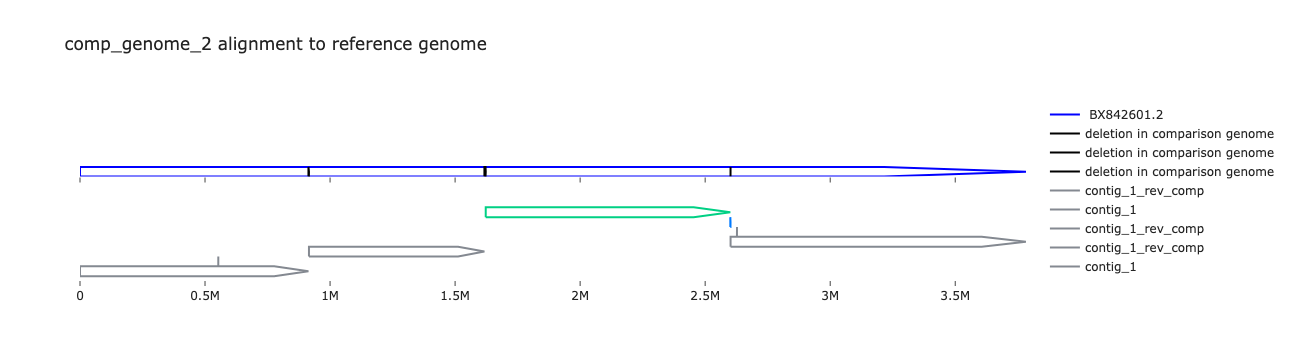

In [33]:
figs_d[name]

In [63]:
def map_location_to_genes(start, end, annot_df): 
    """"""   
    feature_starts = list(annot_df['start'])
    feature_ends = list(annot_df['end'])
    start_index = bisect.bisect_left(feature_ends, start)
    end_index   = bisect.bisect_right(feature_starts, end)
    return annot_df.iloc[start_index:end_index]


def make_gap_dfs(ref_genome_gff_fp, df, ref_genome_len, l=2):
    """feturns genes that contain any gaps >= than given length l"""
    annot_df  = pgf.make_simple_annot_df(ref_genome_gff_fp, start_end=True, contig=True)
    gap_dfs = []
    deletion_id = 1
    for gap in ef.unaligned_segments(df['S1'], df['E1'], ref_len=ref_genome_len):
        s,e = gap
        if abs(s-e) >=  l:
            print(df['Tag2'].iloc[0], e-s, s,e)
            del_gene_df = map_location_to_genes(s, e, annot_df)
            del_gene_df = del_gene_df.copy()
            del_gene_df['deletion_start'] = [s for _ in range(len(del_gene_df))]
            del_gene_df['deletion_end'] = [e for _ in range(len(del_gene_df))]
            del_gene_df['deletion_length'] = [e-s for _ in range(len(del_gene_df))]
            del_gene_df['deletion_id'] = [deletion_id for _ in range(len(del_gene_df))]
            deletion_id+=1
            if len(del_gene_df)>0:
                gap_dfs.append(del_gene_df)
                
    return pd.concat(gap_dfs)


# mark regions in reference that do not align to comparison genome (deletions in comparision genome)
ref_len =  len(ref_genome_d['BX842601.2'])
comp_genome_del_dfs_d = {}
for name, comp_genome_fp in comp_genome_fps.items():  
    comp_genome_del_dfs_d[name] = make_gap_dfs(ref_genome_gff_fp, show_coords_df_d[name], ref_len)
    comp_genome_del_dfs_d[name].to_csv(comp_results_dirs[name] / f"{name.replace('_genome_fp','')}_deletions.csv")

contig_2 4924 1620026 1624950
contig_1 2008 913571 915579
contig_1 5206 1617244 1622450
contig_1 3 2600557 2600560
contig_1 223 2601339 2601562


In [67]:
comp_genome_del_dfs_d['3FF69J_1_1_genome_fp']

,protein_ID,common_name,product,start,end,strand,contig,deletion_start,deletion_end,deletion_length,deletion_id
gene_ID,,,,,,,,,,,
gene-Bd1683,cds-CAE79553.1,neuB,putative N-acetylneuraminic acid synthetase,1619936,1621006,+,BX842601.2,1620026,1624950,4924,1
gene-Bd1684,cds-CAE79554.1,Bd1684,hexapeptide transferase family protein,1621012,1621671,+,BX842601.2,1620026,1624950,4924,1
gene-Bd1685,cds-CAE79555.1,Bd1685,Mannose-1-phosphate guanyltransferase,1621680,1622732,+,BX842601.2,1620026,1624950,4924,1
gene-Bd1686,cds-CAE79556.1,neuA,probable acylneuraminate cytidylyltransferase,1622710,1623402,+,BX842601.2,1620026,1624950,4924,1
gene-Bd1687,cds-CAE79557.1,Bd1687,hypothetical protein predicted by Glimmer/Critica,1623480,1624298,+,BX842601.2,1620026,1624950,4924,1
gene-Bd1688,cds-CAE79558.1,Bd1688,putative polysaccharide biosynthesis protein CpsL,1624303,1625571,+,BX842601.2,1620026,1624950,4924,1


In [66]:
comp_genome_del_dfs_d['3FF69J_2_2_genome_fp']

,protein_ID,common_name,product,start,end,strand,contig,deletion_start,deletion_end,deletion_length,deletion_id
gene_ID,,,,,,,,,,,
gene-Bd0967,cds-CAE78904.1,prc,tail-specific protease,913566,915587,+,BX842601.2,913571,915579,2008,1
gene-Bd0968,cds-CAE78905.1,Bd0968,hypothetical protein predicted by Glimmer/Critica,915560,915745,-,BX842601.2,913571,915579,2008,1
gene-Bd1680,cds-CAE79551.1,neuC,putative UDP-N-acetylglucosamine-2-epimerase NeuC,1617215,1618387,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1681,cds-CAE79552.1,Bd1681,putative formyltransferase,1618384,1619271,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1683,cds-CAE79553.1,neuB,putative N-acetylneuraminic acid synthetase,1619936,1621006,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1684,cds-CAE79554.1,Bd1684,hexapeptide transferase family protein,1621012,1621671,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1685,cds-CAE79555.1,Bd1685,Mannose-1-phosphate guanyltransferase,1621680,1622732,+,BX842601.2,1617244,1622450,5206,2
gene-Bd2680,cds-CAE80471.1,Bd2680,hypothetical protein predicted by Glimmer/Critica,2599160,2603878,-,BX842601.2,2600557,2600560,3,3
gene-Bd2680,cds-CAE80471.1,Bd2680,hypothetical protein predicted by Glimmer/Critica,2599160,2603878,-,BX842601.2,2601339,2601562,223,4


In [47]:
comp_genome_del_dfs_d['comp_genome_2_fp']

,protein_ID,common_name,product,start,end,strand,contig,deletion_start,deletion_end,deletion_length,deletion_id
gene_ID,,,,,,,,,,,
gene-Bd0967,cds-CAE78904.1,prc,tail-specific protease,913566,915587,+,BX842601.2,913571,915579,2008,1
gene-Bd0968,cds-CAE78905.1,Bd0968,hypothetical protein predicted by Glimmer/Critica,915560,915745,-,BX842601.2,913571,915579,2008,1
gene-Bd1680,cds-CAE79551.1,neuC,putative UDP-N-acetylglucosamine-2-epimerase NeuC,1617215,1618387,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1681,cds-CAE79552.1,Bd1681,putative formyltransferase,1618384,1619271,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1683,cds-CAE79553.1,neuB,putative N-acetylneuraminic acid synthetase,1619936,1621006,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1684,cds-CAE79554.1,Bd1684,hexapeptide transferase family protein,1621012,1621671,+,BX842601.2,1617244,1622450,5206,2
gene-Bd1685,cds-CAE79555.1,Bd1685,Mannose-1-phosphate guanyltransferase,1621680,1622732,+,BX842601.2,1617244,1622450,5206,2
gene-Bd2680,cds-CAE80471.1,Bd2680,hypothetical protein predicted by Glimmer/Critica,2599160,2603878,-,BX842601.2,2600557,2600560,3,3
gene-Bd2680,cds-CAE80471.1,Bd2680,hypothetical protein predicted by Glimmer/Critica,2599160,2603878,-,BX842601.2,2601339,2601562,223,4
